### Creating grid for Lake Geneva 

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

#
from scipy.special import erf
from scipy.interpolate import interp1d

from pyproj import Transformer
import os

In [2]:
def SwissGridToLatLon(xSG, ySG):
    '''
    Convert a Swiss coordinate system (xSG, ySG) point to the geographic
    coordinate system in accordance with the formulas given in 'Approximate
    formulas for the transformation between Swiss projection coordinates
    and WGS84'.
    '''

    yPrime = (xSG - 2600000) / 1000000
    xPrime = (ySG - 1200000) / 1000000

    longitudePrime = ( 2.6779094 +
                       4.728982  * yPrime +
                       0.791484  * xPrime*yPrime +
                       0.1306    * yPrime*xPrime**2 -
                       0.0436    * yPrime**3 )
    latitudePrime = ( 16.9023892 +
                      3.238272   * xPrime -
                      0.270978   * yPrime**2 -
                      0.002528   * xPrime**2 -
                      0.0447     * xPrime*yPrime**2 -
                      0.0140     * xPrime**3 )

    longitude = (100./36.) * longitudePrime
    latitude  = (100./36.) * latitudePrime

    return (latitude, longitude)

####  XY grid
- Cartesian grid (origin is at 0,0)
- dx, dy = 120m (horizontal resolution)
- Nx=54, Ny=120 (number of cells in x and y)


##### no. of CPUs: 72
- sNx = 9, sNy = 10 (number of cells in each tile)
- nPx = 6, nPy = 12 (number of processes in X and Y)
- Grid: 6480m * 14400m


#### Point of origin on Swiss Grid 
- XO_SG = 2676648
- YO_SG = 1212416


In [3]:
def translate_grid_to_origin(x: np.ndarray, y: np.ndarray, dx: float, dy: float) -> (np.ndarray, np.ndarray):
    trans_x = x + dx
    trans_y = y + dy
    
    return trans_x,trans_y

def get_grid_angle(x0: float, y0: float, x1: float, y1: float)-> float:
    grid_angle = np.arctan2(y1 - y0, x1 - x0)

    return grid_angle

def rotate_grid(x: np.ndarray, y: np.ndarray, x0: float, y0: float, rotation_angle: float) -> (np.ndarray, np.ndarray):
    x_translated_to_zero, y_translated_to_zero = translate_grid_to_origin(x, y, -x0, -y0)

    x_rotated = np.cos(rotation_angle) * x_translated_to_zero - np.sin(rotation_angle) * y_translated_to_zero
    y_rotated = np.sin(rotation_angle) * x_translated_to_zero + np.cos(rotation_angle) * y_translated_to_zero

    x_translated_back, y_translated_back = translate_grid_to_origin(x_rotated, y_rotated, x0, y0)

    return x_translated_back, y_translated_back

In [4]:
path_out = r'C:\Users\leroquan\Documents\00-Work_space\06-mit_gcm_geneva\data\grid\50m'
dx=50;dy=50
Nx=1344; Ny=528  #Ny initially set to 120

# point of origin in swiss grid 
XO_SG = 500000
YO_SG = 116500

# second point for tilted grid
X1_SG = 563000
Y1_SG = 138700

# XY on mitgcm grid 
x = np.arange(0,Nx*dx,dx)
y = np.arange(0,Ny*dy,dy)

xgrid, ygrid = (np.meshgrid(x,y))

# XY on swiss grid 
x_sg = x + XO_SG
y_sg = y + YO_SG

xsg_grid, ysg_grid = np.meshgrid(x_sg,y_sg)

angle = get_grid_angle(XO_SG, YO_SG, X1_SG, Y1_SG)

x_rotated, y_rotated = rotate_grid(xsg_grid, ysg_grid, x_sg[0], y_sg[0], angle)

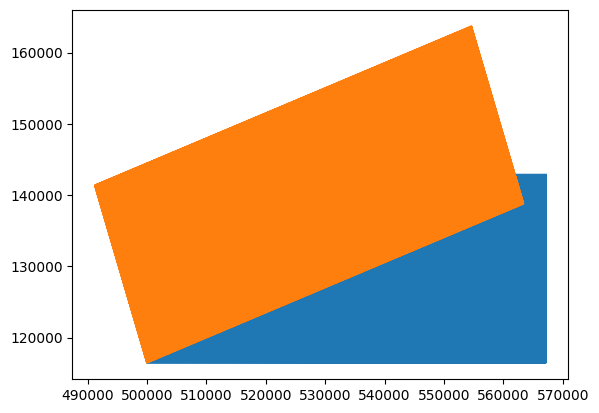

In [5]:
plt.plot(xsg_grid.flatten(), ysg_grid.flatten())
plt.plot(x_rotated.flatten(), y_rotated.flatten())

In [6]:
coord_converter = Transformer.from_crs("EPSG:21781", "EPSG:4326", always_xy=True)
lon_grid, lat_grid = coord_converter.transform(x_rotated,y_rotated)

#### longitude changes slightly

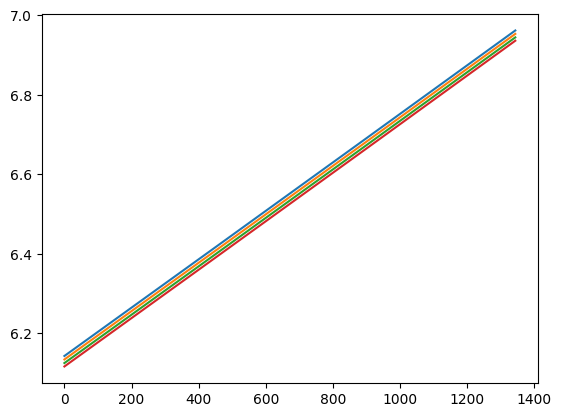

In [7]:
plt.plot(lon_grid[1,:])
plt.plot(lon_grid[40,:])
plt.plot(lon_grid[80,:])
plt.plot(lon_grid[118,:])


In [8]:
with open(os.path.join(path_out, 'x.npy'), 'wb') as f:
    np.save(f, x)

with open(os.path.join(path_out, 'y.npy'), 'wb') as f:
    np.save(f, y)

with open(os.path.join(path_out, 'x_sg_grid.npy'), 'wb') as f:
    np.save(f, x_rotated)

with open(os.path.join(path_out, 'y_sg_grid.npy'), 'wb') as f:
    np.save(f, y_rotated)

with open(os.path.join(path_out, 'lat_grid.npy'), 'wb') as f:
    np.save(f, lat_grid)

with open(os.path.join(path_out, 'lon_grid.npy'), 'wb') as f:
    np.save(f, lon_grid)

#### Z-grid
- dz should be increasing (without big jumps)
- above 30m: 1m 
- below 30m: 5m
- below 160m: coaser??
- try out exponential curve if vertical cells have to be much coarser at depth 



Nz = 200 #defining total number of cells
dz_first = 1.2
dz_last = 3.4
# Calculate the step size between successive values
first_value = 0
step_sizes = np.linspace(dz_first, dz_last, Nz)

# Create the array by cumulative summing the step sizes
Z = np.cumsum(step_sizes)

# Shift and scale the array to start from 0 and end at 200
Z = (Z - Z[0]) / (Z[-1] - Z[0]) * 200

# dz but ensuring that len(dz) = Nz
dz = np.interp(Z, Z[:-1] + np.diff(Z) / 2, np.diff(Z))
plt.plot(dz, -Z)
plt.grid()

with open(path_out + 'z.npy', 'wb') as f:
    np.save(f, -Z)

with open(path_out + 'dz.npy', 'wb') as f:
    np.save(f, dz)